In [23]:
using JuMP, Ipopt
using PyPlot

┌ Info: Recompiling stale cache file /Users/hdrake/.julia/compiled/v1.2/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1240


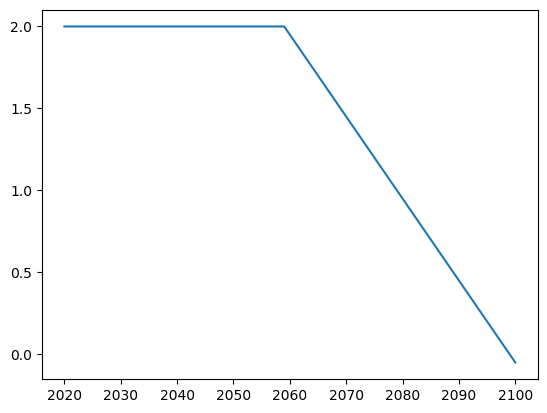

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1475cec18>

In [247]:
dt = 1
t = [2020:dt:2100;] # years
tidx = 1:1:81
N = length(t)   # number of years
CO₂_init = 415    # concentration(ppm) initially

# physical climate parameters
ECS = 3        # Equilibrium Climate Sensitivity
ϵ = ECS/log(2) # Transient Warming Parameter
δT₀_init = 1.1;    # Warming: initial, preindustrial

# baseline emissions scenarios
q = fill(2.,N) # emissions scenario
q[40:end] = 2. .* (40. .-(0.:1.:41.))/40.
c₀ = CO₂_init .+ cumsum(q); # cumulative CO2 concentrations (ppm)
δT_0 = δT₀_init .+ ϵ.*log.(c₀/CO₂_init) # warming due to baseline emissions scenario

# economic parameters
β = 2.2 # damage parameter (trillion dolars / C^2)
D_0 = β .* δT₀_init.^2; # baseline damages
γ = 0 #1. /30. # discount rate
ρ = 0.03
C_ϕ = 400 # Negative (emissions) trillion $
C_φ = 100 # Reduction (of emissions) trillion $
C_χ = 150 # Adaptation trillion $
C_λ = 150 # Geoengineering trillion $

c(ϕ::Array, φ::Array) = (c₀ .- cumsum(q .* φ)) .* (1. .- ϕ);
δT(ϕ::Array, φ::Array) = δT₀_init .+ ϵ.*log.(c(ϕ,φ)./CO₂_init);

f_low(α) = (α / (1. .+α))^2 # shape of individual cost functions

# Damage
D(ϕ::Array, φ::Array, χ::Array, λ::Array) = (1 .- χ) .* β .* δT(ϕ, φ).^2 .* (1 .- λ).^2

# Cost
C(ϕ::Array, φ::Array, χ::Array, λ::Array) = C_λ.*f_low(λ) .+ C_ϕ.*f_low(ϕ) .+ C_φ.*f_low(φ) .+ C_χ.*f_low(χ)

# Objective
T(ϕ::Array, φ::Array, χ::Array, λ::Array) = (
    sum((C(ϕ, φ, χ, λ) .+ D(ϕ, φ, χ, λ)) .* exp.(.-γ.*(t.-t[1]))) .+
    1000. * (sum(diff(ϕ).^2) .+ sum(diff(φ).^2) .+ sum(diff(χ).^2) .+ sum(diff(λ).^2)) .+
    1000. .* (ϕ[1].^2 .+ φ[1].^2 .+ χ[1].^2 .+ λ[1].^2)
)

plot(t,q)

In [269]:
model = Model(with_optimizer(Ipopt.Optimizer, print_level=0))

f_low(α) = (α / (1. .+α))^2 # shape of individual cost functions
register(model, :f_low, 1, f_low, autodiff=true)

A = [i ≥ j for i∈1:N, j∈1:N] # cumsum matrix

δT(ϕ,φ) = δT₀_init + ϵ * log.( ((c₀[i] .- A*(q * φ)) * (1. - ϕ) ) / (CO₂_init ))
register(model, :δT, 2, δT, audodiff=true)

@variables(model, begin
        0. <= ϕ[1:N] <= 1.
        0. <= φ[1:N] <= 1.
        0. <= χ[1:N] <= 1.
        0. <= λ[1:N] <= 1.
end)

@constraint(model, conϕ, ϕ[1] == 0)
@constraint(model, conφ, φ[1] == 0)
@constraint(model, conλ, λ[1] == 0)
@constraint(model, conχ, χ[1] == 0)

@NLobjective(model, Min,
    sum(C_ϕ*f_low(ϕ[i])*dt +
        C_λ*f_low(λ[i])*dt +
        C_φ*f_low(φ[i])*dt +
        C_χ*f_low(χ[i])*dt for i=1:N
    ) +
    sum( (1. - χ[i])* β * δT(ϕ,φ)[i]^2 * (1. - λ[i])^2
        * (1. / (1. + ρ))^tidx[i]
    for i=1:N)
)
model;

MethodError: MethodError: no method matching register(::Model, ::Symbol, ::Int64, ::typeof(δT); audodiff=true)
Closest candidates are:
  register(::Model, ::Symbol, ::Integer, ::Function; autodiff) at /Users/hdrake/.julia/packages/JuMP/MsUSY/src/nlp.jl:1153 got unsupported keyword argument "audodiff"
  register(::Model, ::Symbol, ::Integer, ::Function, !Matched::Function; autodiff) at /Users/hdrake/.julia/packages/JuMP/MsUSY/src/nlp.jl:1169 got unsupported keyword argument "audodiff"
  register(::Model, ::Symbol, ::Integer, ::Function, !Matched::Function, !Matched::Function) at /Users/hdrake/.julia/packages/JuMP/MsUSY/src/nlp.jl:1185 got unsupported keyword argument "audodiff"

In [249]:
optimize!(model)
[value.(ϕ) value.(φ) value.(χ) value.(λ)]

81×4 Array{Float64,2}:
 0.0         0.0         0.0          0.0       
 2.45541e-6  5.13705e-6  0.00828181   0.0171585 
 2.45541e-6  5.13705e-6  0.00804326   0.0166463 
 2.45541e-6  5.13705e-6  0.00781149   0.0161497 
 2.45541e-6  5.13705e-6  0.00758631   0.0156683 
 2.45541e-6  5.13705e-6  0.00736753   0.0152015 
 2.45541e-6  5.13705e-6  0.00715499   0.0147489 
 2.45541e-6  5.13705e-6  0.00694851   0.0143101 
 2.45541e-6  5.13705e-6  0.00674791   0.0138846 
 2.45541e-6  5.13705e-6  0.00655305   0.0134721 
 2.45541e-6  5.13705e-6  0.00636375   0.013072  
 2.45541e-6  5.13705e-6  0.00617987   0.012684  
 2.45541e-6  5.13705e-6  0.00600125   0.0123077 
 ⋮                                              
 2.45541e-6  5.13705e-6  0.0011194    0.00224892
 2.45541e-6  5.13705e-6  0.00108684   0.0021832 
 2.45541e-6  5.13705e-6  0.00105522   0.00211941
 2.45541e-6  5.13705e-6  0.00102451   0.00205749
 2.45541e-6  5.13705e-6  0.000994706  0.00199739
 2.45541e-6  5.13705e-6  0.000965763  0.001939

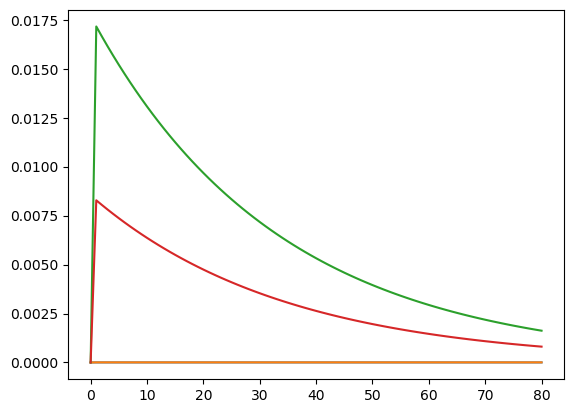

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x147b5e518>

In [250]:
plot(value.(ϕ))
plot(value.(φ))
plot(value.(λ))
plot(value.(χ))

In [ ]:
@NLobjective(model, Min,
    sum(C_ϕ*f_low(ϕ[i])*dt +
        C_λ*f_low(λ[i])*dt +
        C_φ*f_low(φ[i])*dt +
        C_χ*f_low(χ[i])*dt for i=1:N
    ) +
    sum( (1. - χ[i])* β * (δT₀_init + ϵ*log.( (c₀[i] .- (A*q)[i]) /CO₂_init ))^2 * (1. - λ[i])^2
        * (1. / (1. + ρ))^tidx[i]
    for i=1:N)
)

In [240]:
model = Model(with_optimizer(Ipopt.Optimizer, print_level=0))
#register(model, :f_low, 1, f_low, autodiff=true)

@variables(model, begin
        0. <= ϕ[2:N] <= 1.
        0. <= φ[2:N] <= 1.
        0. <= χ[2:N] <= 1.
        0. <= λ[2:N] <= 1.
end)

A = [i ≥ j for i∈1:N, j∈1:N] # cumsum matrix
Δ = zeros(N-1,N)
for i=1:N-1
    Δ[i,i] = 1.0
    Δ[i,i+1] = -1.0
end

@variable(model,   cumsum_qφ[1:N])
@variables(model, begin
        dϕ[1:N-1]
        dφ[1:N-1]
        dχ[1:N-1]
        dλ[1:N-1]
        end)

@NLconstraint(model, cumsum_qφ .== A*(q.*(1. .-φ)))
@NLconstraint(model, CO₂ .== (cumsum_qφ + CO₂_init) * (1. - ϕ))
@NLconstraint(model, dϕ .== Δ*ϕ)
@NLconstraint(model, dφ .== Δ*φ)
@NLconstraint(model, dχ .== Δ*χ)
@NLconstraint(model, dλ .== Δ*λ)

# no controls at present day
@NLconstraint(model,ϕ[1] .== 0.0)
@NLconstraint(model,φ[1] .== 0.0)
@NLconstraint(model,χ[1] .== 0.0)
@NLconstraint(model,λ[1] .== 0.0)

@NLobjective(model, Min, sum(C_λ*f_low(λ[i]) +
                             C_ϕ*f_low(ϕ[i]) +
                             C_φ*f_low(φ[i]) +
                             C_χ*f_low(χ[i]) for i=1:N)
     + sum(
        (1 - χ[i])*β *
        (δT₀_init+ϵ*log(CO₂ / CO₂_init))^2 *
        (1 - λ[i])^2 *
        exp(-γ*(t[i]-t[1]))  for i=1:N)
)

LoadError: in @NLconstraint (cumsum_qφ .== A * (q .* (1.0 .- φ))): expected comparison operator (<=, >=, or ==).

In [241]:
model

A JuMP Model
Feasibility problem with:
Variables: 721
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 320 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 320 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Ipopt
Names registered in the model: cumsum_qφ, dλ, dφ, dχ, dϕ, λ, φ, χ, ϕ

In [63]:
optimize!(model)

In [64]:
[value.(ϕ) value.(φ) value.(χ) value.(λ)]

81×4 Array{Float64,2}:
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 ⋮                                     
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.122765  0.122765  0.122765
 0.122765  0.1227

# Alan's objective

```Julia
@NLobjective(model, Min, sum(C_λ*f_low(λ[i]) +
                             C_ϕ*f_low(ϕ[i]) +
                             C_φ*f_low(φ[i]) +
                             C_χ*f_low(χ[i]) for i=1:N)
     + sum(
        (1 - χ[i])*β *
        (δT₀_init+ϵ*log(cumsum_qφ[i]/CO₂_init))^2 *
        (1 - λ[i])^2 *
        exp(-γ*(t[i]-t[1]))  for i=1:N)
    +  1000 * sum(dϕ[i]^2 +dφ[i]^2 + dλ[i]^2 + dχ[i]^2 for i=1:N-1)+
        1000 * (ϕ[1]^2 + φ[1]^2 + χ[1]^2 + λ[1]^2)
    )
```